In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from importlib import reload
import os, sys, re, glob, time, pickle, IPython, logging
import scipy.ndimage as ndi
from itertools import islice
import torch
from torch import nn, optim
from torch.nn import functional as F
#from torchmore import layers, flex
#import torchtrainers as tt
from torch.utils.data import DataLoader
from webdataset import WebDataset, WebLoader
from ocropus4train import ocrhelpers as helpers
from ocropus4train.ocrhelpers import *
from ocropus4train import ocrmodels2 as models
import scipy
import scipy.ndimage
import ocrodeg
import imageio.v2 as imageio
import braceexpand

RUN("date")
RUN("hostname")
RUN("whoami")
RUN("nvidia-smi -L")

os.environ["GOPEN_VERBOSE"] = "0"
os.environ["WDS_VERBOSE_CACHE"] = "0"

date : Fri May  5 11:10:27 PM PDT 2023
hostname : bragi
whoami : tmb
nvidia-smi -L : GPU 0: NVIDIA TITAN X (Pascal) (UUID: GPU-a964bb9a-cb1a-5036-e1d8-1217c1faa8e7)
GPU 1: NVIDIA TITAN X (Pascal) (UUID: GPU-a16b9686-b668-e8d5-ff5f-f85aea86d034)


In [3]:
training_urls = list(braceexpand.braceexpand("gs://ocro-iaa/words/books-{000001..000653}-words.tar"))
training_urls += list(braceexpand.braceexpand("gs://ocro-iaa/lines/books-{000001..000653}-lines.tar"))
testing_urls = "gs://ocro-iaa/words/books-000000-words.tar"

batch_size = 4

#training_urls = "data/words-simple-training.tar"
#testing_urls = "data/words-simple-testing.tar"

In [4]:
chars = [chr(i) for i in range(32, 127)]
charset = DefaultCharset(chars)


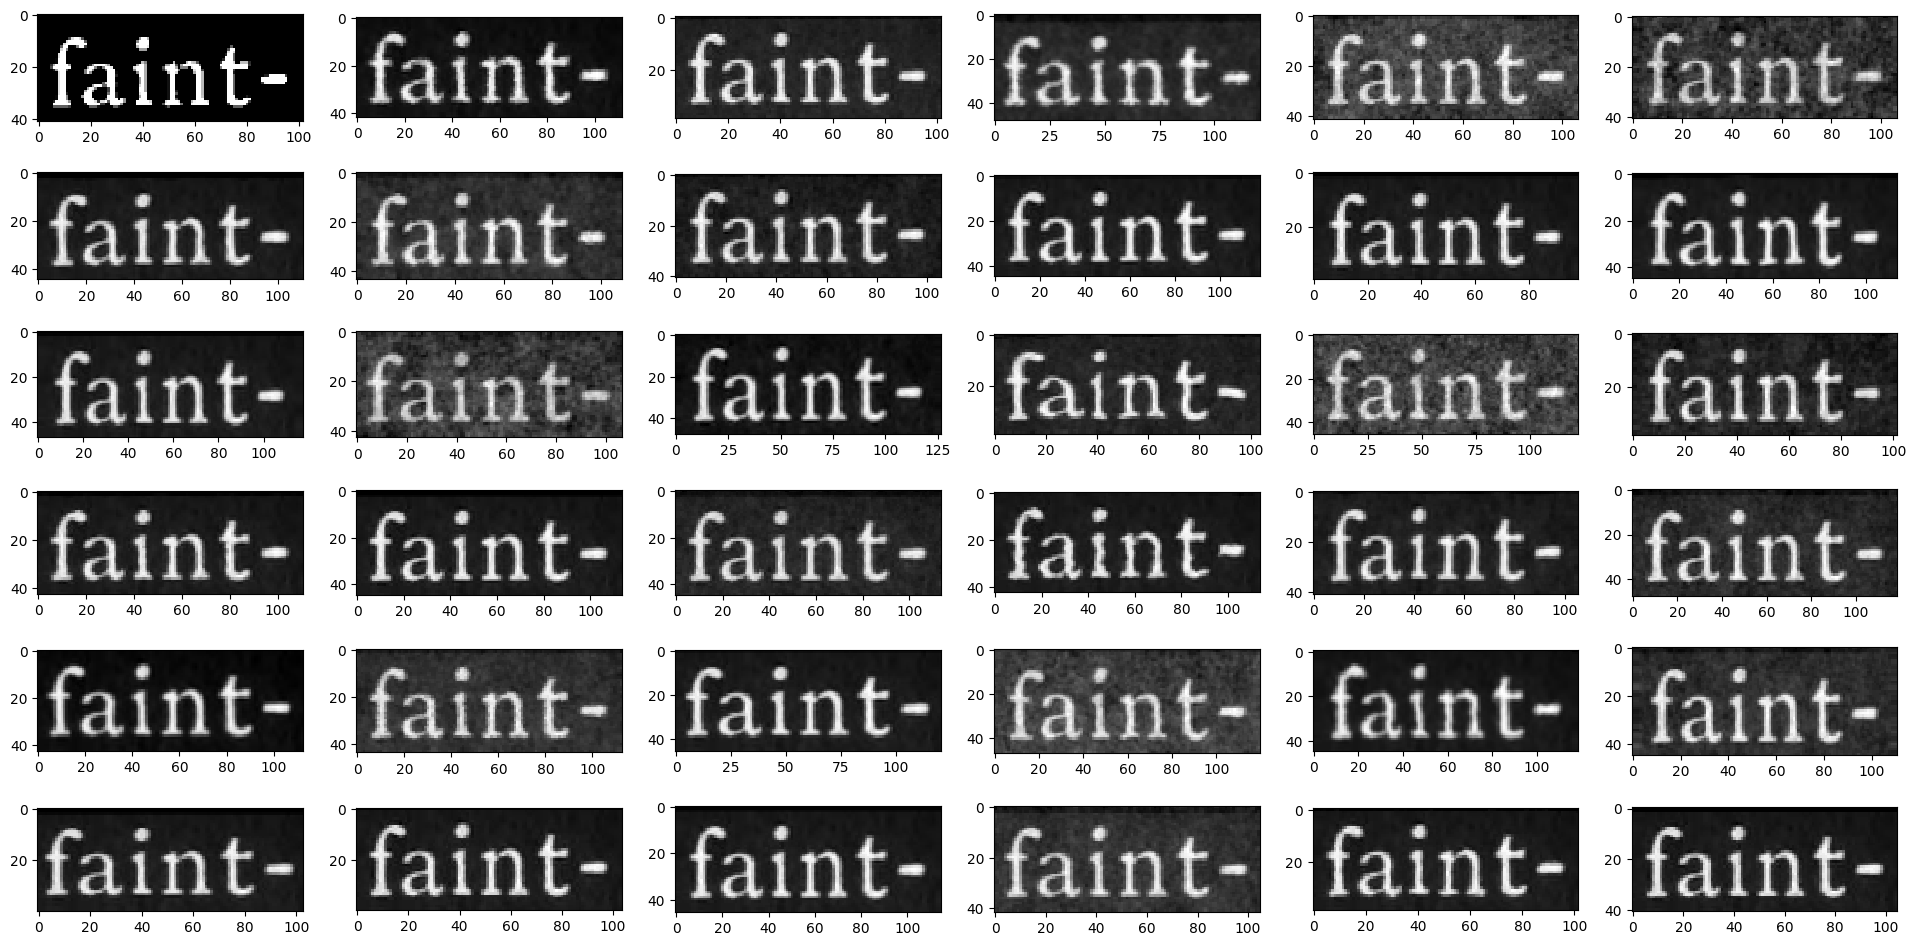

In [5]:
# augmentations:
# - autocrop
# - shift, scale
# - threshold
# - noise, offset, contrast

from ocropus4train.ocraugment import maybe, aniso, distort, normalize, height_normalize, autoinvert, make_noise, threshold, noisify

def random_padding(a, target):
    if a.shape[0] < target-1:
        # for smaller images, add random padding to the top
        d = random.randint(0, int(target - a.shape[0])-1)
        a = np.pad(a, ((d, 0), (0, 0)))
    else:
        # for larger images, add up to 10% random padding to the top
        d = random.randint(0, int(a.shape[0] * 0.1)-1)
        a = np.pad(a, ((d, 0), (0, 0)))
    return a

def preprocess(a, target=48.0):
    assert isinstance(a, np.ndarray)
    assert a.ndim == 2
    a = normalize(a)
    a = autoinvert(a)
    a = random_padding(a, target)
    if maybe(0.5):
        a = noisify(a)
    if maybe(0.5):
        a = distort(a)
    if maybe(0.5):
        a = aniso(a)
    if maybe(0.1):
        sigma = 10**random.uniform(-0.3, 0.3)
        a = scipy.ndimage.gaussian_filter(a, sigma)
        a = normalize(a)
    if maybe(0.1):
        a = threshold(a)
    if target is not None:
        a = height_normalize(a, target*(1.0 + random.uniform(-0.2, 0.0)))
    assert a.ndim == 2
    return a


figsize(24, 12)
testimg = imageio.imread("samples/word.jpg")
for i in range(36):
    subplot(6, 6, i+1)
    imshow(preprocess(testimg))
plt.show()

In [6]:
def good(sample):
    img, txt = sample
    if img.shape[-1] < 10 or img.shape[-2] < 10 or img.shape[-1] > 2500 or img.shape[-2] > 150:
        # print("bad image size", img.shape)
        return None
    return img, txt

def usm_image(img):
    img = img - ndi.gaussian_filter(img, 16.0, mode="nearest")
    return img

def img_tensor(img):
    assert img.ndim == 2, img.shape
    assert img.dtype == np.float32, img.dtype
    assert np.amax(img) < 10.0  # make sure it already got normalied somewhere
    return torch.tensor(img).unsqueeze(0)

def str_tensor(s):
    assert isinstance(s, str)
    return torch.tensor(charset.encode(s)).long()

def pipeline(ds):
    return ds.decode("l8").to_tuple("jpg;jpeg;ppm;png txt").map(good).map_tuple(preprocess).map_tuple(usm_image).map_tuple(img_tensor, str_tensor)

training = pipeline(WebDataset(training_urls, resampled=True).shuffle(20000))
testing = pipeline(WebDataset(testing_urls))
training_dl = WebLoader(training, batch_size=batch_size, collate_fn=helpers.collate4ocr, num_workers=8).with_epoch(100000//batch_size)
testing_dl = WebLoader(testing, batch_size=batch_size, collate_fn=helpers.collate4ocr, num_workers=4)
images, sequences = next(iter(training_dl))
assert images.shape[-2] <= 48, images.shape
print(images.shape)

# downloading gs://ocro-iaa/lines/books-000526-lines.tar to /home/tmb/gs/lines/books-000526-lines.tar# downloading gs://ocro-iaa/lines/books-000398-lines.tar to /home/tmb/gs/lines/books-000398-lines.tar# downloading gs://ocro-iaa/lines/books-000181-lines.tar to /home/tmb/gs/lines/books-000181-lines.tar# downloading gs://ocro-iaa/lines/books-000104-lines.tar to /home/tmb/gs/lines/books-000104-lines.tar# downloading gs://ocro-iaa/lines/books-000594-lines.tar to /home/tmb/gs/lines/books-000594-lines.tar
# downloading gs://ocro-iaa/lines/books-000230-lines.tar to /home/tmb/gs/lines/books-000230-lines.tar




# downloading gs://ocro-iaa/lines/books-000519-lines.tar to /home/tmb/gs/lines/books-000519-lines.tar
# downloading gs://ocro-iaa/lines/books-000028-lines.tar to /home/tmb/gs/lines/books-000028-lines.tar
GOPEN gs://ocro-iaa/lines/books-000181-lines.tar GOPENGOPENGOPENGOPEN{} GOPENGOPEN   
gs://ocro-iaa/lines/books-000519-lines.tar gs://ocro-iaa/lines/books-000104-lines.targs://ocro-iaa

torch.Size([4, 1, 47, 773])


In [7]:
mname = "lstm_resnet_v3"
model = models.make(mname, noutput=len(charset))
# ensure it can be jitted
torch.jit.script(model);
model

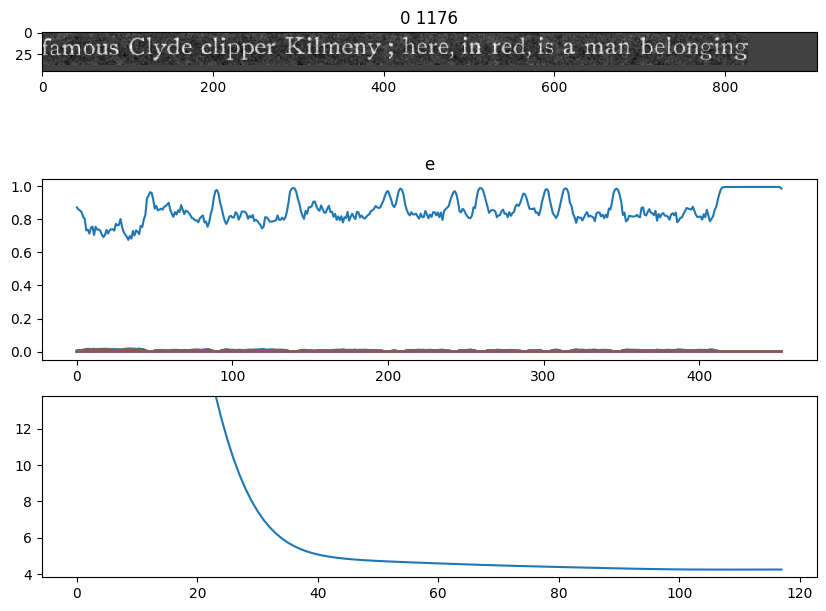

In [8]:
import time
errors = [(-1, time.time())]

for trial in range(10):
    model = models.make(mname, noutput=len(charset))
    trainer = helpers.LineTrainer(model, charset=charset, lr=1e-5)
    trainer.load_best()
    try:
        trainer.train(training_dl, 10, every=15, learning_rates=[1e-4]*3 + [1e-5]*200)
    except helpers.NanError:
        errors += [(trial, time.time())]
        print("NaN Error during training, restarting and reloading from last checkpoint")
        time.sleep(10)
